In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_07 import *

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs))

In [ ]:
nfs = [8,16,16]

## Momentum

### Base optimizer

In [ ]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, lr=0.4): super().__init__(params, dict(lr=lr))
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None: p.data.add_(-pg['lr'], self.get_step(pg, p))
                    
    def get_step(self, pg, p): return p.grad.data

In [ ]:
def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight, a=0.1)

def get_runner(model, opt_func, cbs=None, loss_func = F.cross_entropy):
    opt = opt_func(model.parameters())
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner([AvgStatsCallback([accuracy]), CudaCallback(),
        BatchTransformXCallback(resize_tfm(1,28,28))] + listify(cbs))

def get_learn_run(nfs, opt_func, cbs=None):
    model =  nn.Sequential(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
    init_cnn(model)
    return get_runner(model, opt_func, cbs=cbs)

In [ ]:
nfs = [8,16,32,32]

In [ ]:
learn,run = get_learn_run(nfs, partial(Optimizer, lr=0.8))

In [ ]:
%time run.fit(1, learn)

train: [0.495275390625, tensor(0.8583, device='cuda:0')]
valid: [0.2201855712890625, tensor(0.9336, device='cuda:0')]
CPU times: user 887 ms, sys: 43.8 ms, total: 931 ms
Wall time: 932 ms


### Implement momentum

In [ ]:
class MomentumStats():
    def __init__(self, mom=0.9): self.mom,self.step = mom,None
    
    def update(self, grad):
        if self.step is None: self.step = grad.clone()
        else: self.step.mul_(self.mom).add_(grad)
        return self.step

In [ ]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, stats_func, lr=0.4):
        super().__init__(params, lr=lr)
        self.stats_func = stats_func

    def get_state(self, p):
        # First time this param seen - create a stats obj for it and put it in `state`
        if p not in self.state: self.state[p] = self.stats_func()
        return self.state[p]
    
    def get_step(self, pg, p):
        # PyTorch will save anything stored in `state`; it's indexed by param
        stats = self.get_state(p)
        return stats.update(p.grad.data)

In [ ]:
model = get_cnn_model(data, nfs)
opt_func = partial(StatefulOptimizer, stats_func=MomentumStats, lr=0.2)
learn,run = get_runner(model, opt_func)

In [ ]:
%time run.fit(3, learn)

train: [0.375792578125, tensor(0.8923, device='cuda:0')]
valid: [0.09427047119140625, tensor(0.9714, device='cuda:0')]
train: [0.0745775341796875, tensor(0.9770, device='cuda:0')]
valid: [0.06685537719726563, tensor(0.9802, device='cuda:0')]
train: [0.053985537109375, tensor(0.9832, device='cuda:0')]
valid: [0.07678325805664063, tensor(0.9792, device='cuda:0')]
CPU times: user 2.41 s, sys: 87.4 ms, total: 2.5 s
Wall time: 2.5 s


### Momentum experiments

In [ ]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5,0.7,0.9,0.99]

In [ ]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = 0,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

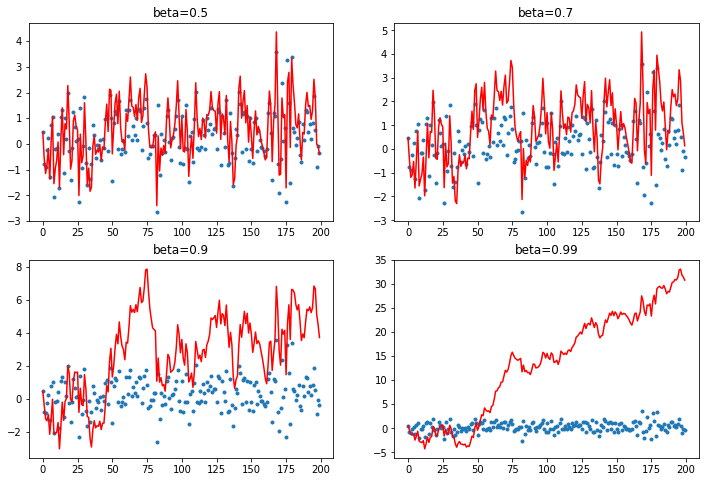

In [ ]:
def mom1(avg, beta, yi, i): 
    res = beta * avg + yi
    return res,res
plot_mom(mom1)

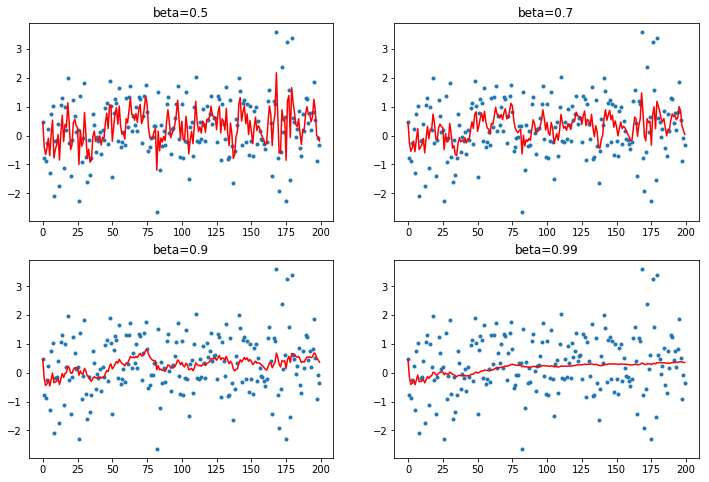

In [ ]:
def mom2(avg, beta, yi, i):
    avg = beta * avg + (1-beta) * yi
    return avg, avg/(1-beta**(i+1))
plot_mom(mom2)

In [ ]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

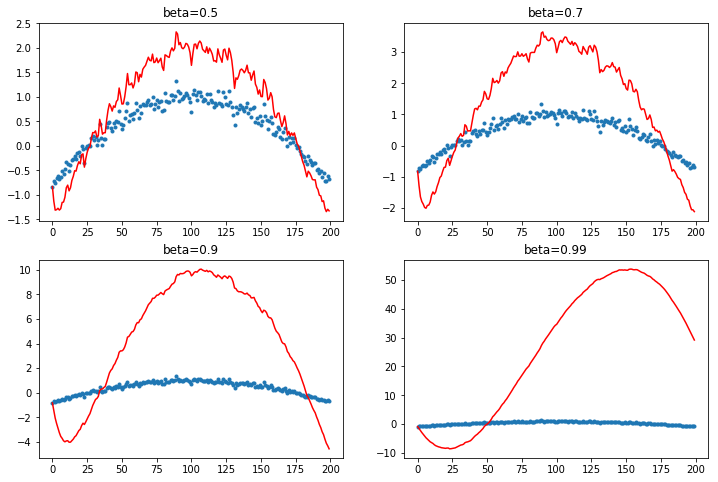

In [ ]:
plot_mom(mom1)

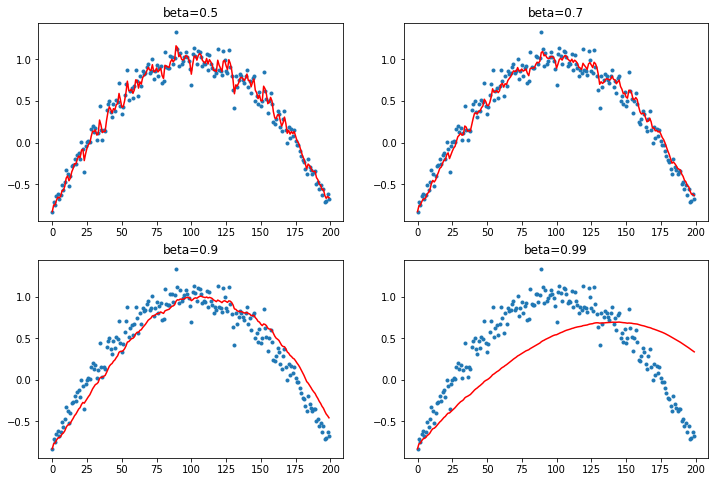

In [ ]:
plot_mom(mom2)

### Adam and friends

In [ ]:
class GradStats():
    def __init__(self, grad_mom=0, sqr_mom=0, grad_damp=None, sqr_damp=None, eps=1e-4):
        if grad_damp is None: grad_damp = 1-grad_mom
        if sqr_damp is None:  sqr_damp  = 1-sqr_mom
        self.grad_mom ,self.sqr_mom  = grad_mom ,sqr_mom
        self.grad_damp,self.sqr_damp = grad_damp,sqr_damp
        self.eps,self.grad_avg = eps,None
    
    def update(self, grad):
        if self.grad_avg is None:
            self.grad_avg,self.sqr_avg = torch.zeros_like(grad),torch.zeros_like(grad)
            self.iter = 0

        self.iter += 1
        # Inplace version of:
        # self.sqr_avg  = self.sqr_avg *self.sqr_mom  + (grad*grad)*self.sqr_damp
        self.grad_avg.mul_(self.grad_mom).add_    (self.grad_damp,grad)
        self.sqr_avg .mul_(self.sqr_mom ).addcmul_(self.sqr_damp ,grad,grad)
        # If grad_damp==1-grad_mom:
        # debias1 = 1 - self.grad_mom**self.iter
        debias1 = self.grad_damp * (1 - self.grad_mom**self.iter) / (1-self.grad_mom)
        debias2 = self.sqr_damp  * (1 - self.sqr_mom **self.iter) / (1-self.sqr_mom )
        return self.grad_avg/debias1 / (self.sqr_avg/debias2 + self.eps)

In [ ]:
model = get_cnn_model(data, nfs)
ws = partial(GradStats, grad_mom=0.9, sqr_mom=0.99)
opt_func = partial(StatefulOptimizer, lr=0.001, stats_func=ws)
learn,run = get_runner(model, opt_func)

In [ ]:
%time run.fit(3, learn)

train: [0.30656873046875, tensor(0.9077, device='cuda:0')]
valid: [0.12986187744140626, tensor(0.9602, device='cuda:0')]
train: [0.0797887646484375, tensor(0.9751, device='cuda:0')]
valid: [0.13252254638671876, tensor(0.9605, device='cuda:0')]
train: [0.0589289453125, tensor(0.9815, device='cuda:0')]
valid: [0.06850303955078126, tensor(0.9816, device='cuda:0')]
CPU times: user 2.84 s, sys: 171 ms, total: 3.01 s
Wall time: 3.01 s


## Export

In [ ]:
!./notebook2script.py 08_optimizers.ipynb

Converted 08_optimizers.ipynb to nb_08.py
